In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from modeling.vit_attention import OpenCLIPAttentionViT
from visualize.base import construct_per_layer_output_dict


# SECTION: Set up model
torch.set_default_device(DEVICE)
model = OpenCLIPAttentionViT({}, stop_layer=None).to(DEVICE)


# SECTION: Set up monitor
def residual_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return input_ + tree_flatten(output_)[0][0]
    
def input_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return tree_flatten(input_)[0][0]

def mean_attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return torch.mean(einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ), dim=-1).to(OUTPUT_DEVICE)

def attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ).to(OUTPUT_DEVICE)
    
def get_weight_by_name(name: str) -> Callable[[nn.Module, Any, Any], Any]:
    def hook(model_: nn.Module, input_: Any, output_: Any) -> Any:
        return utils.rgetattr(model_, name).data
    return hook


monitor_config = OrderedDict({
    "model.visual.transformer.resblocks": OrderedDict({
        "": [
            ("layer_input", input_hook_fn),
            ("layer_output", Monitor.default_hook_fn),
        ],
        "attn.return_unmasked_attn_matrix": [
            ("unmasked_attention_matrix", attention_matrix_hook_fn)
        ],
        "ln_1": "attention_input",
    })
})

monitor = Monitor(model, monitor_config)
model_weights_config = OrderedDict({
    "attn": OrderedDict({
        "in_proj_weight": "QKVw",
        "in_proj_bias": "QKVb",
        "out_proj.weight": "out_w",
        "out_proj.bias": "out_b",
    })
})


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))
# original_images, images = torch.flip(original_images, dims=[0]), torch.flip(images, dims=[0])


# SECTION: Run baseline model
per_metric_output_dict = monitor.reset()
with torch.no_grad():
    output = model.forward(images)

per_layer_output_dict: List[TensorDict] = construct_per_layer_output_dict(per_metric_output_dict)
model_weights: List[Dict[str, torch.Tensor]] = [{
    v: resblock.get_parameter(k).data
    for k, v in utils.flatten_nested_dict(model_weights_config).items()
} for resblock in model.get_submodule("model.visual.transformer.resblocks")]

In [3]:
# SECTION: Visualize original images
%matplotlib inline
from modeling.image_features import ImageFeatures
from core.attention_sink import mask_attention_sink
from visualize.base import (
    visualize_images_with_mta,
    visualize_feature_norms_per_image,
    get_rgb_colors,
)

# SECTION: Massive token heuristic
MA_mask: torch.Tensor = torch.load(f"experiments/saved_masks/MA_mask{batch_size}.pt", map_location=DEVICE)
AS_mask: torch.Tensor = torch.load(f"experiments/saved_masks/ranked_AS_mask{batch_size}.pt", map_location=DEVICE).isfinite()
mta_masks: Dict[int, torch.Tensor] = {
    "MA": MA_mask,
    "Artifact": AS_mask * ~MA_mask,
}
features = ImageFeatures(per_layer_output_dict, mta_masks, "default", DEVICE)

In [4]:
from visualize.base import CMAPScaleOptions
from visualize.attention import visualize_attention_matrix_per_layer


def visualize_attention_suppression_per_layer(
    layer_indices: List[int],
    features: ImageFeatures,
    model_weights: List[Dict[str, torch.Tensor]],
    empirical: bool,
    normalize: bool,
    
    name_to_mask: Dict[str, torch.Tensor],
    transform_func: Callable[[torch.Tensor], torch.Tensor] = None,
    order_by_tsne: bool = False,
    per_head: bool = False,
    rescale_func: Callable[[torch.Tensor], torch.Tensor] = None,
    global_cmap: bool = True,
    cmap_scale: CMAPScaleOptions = "linear",
    subsample: float = 1.0,
    spacing: float = 0.1,
    save_fname: str = None,
    **kwargs: Any,
) -> torch.Tensor:
    bsz = features.shape[1]
    
    pairwise_suppression_projections = torch.empty((max(layer_indices) + 1, bsz, ImageFeatures.N + 1, ImageFeatures.N + 1, 16))
    
    for layer_idx in layer_indices:
        x = features.get(layer_idx, "layer_input", include=(ImageFeatures.CLS, ImageFeatures.IMAGE,))           # [(bsz x n) x embed_dim]
        ln1_x = features.get(layer_idx, "attention_input", include=(ImageFeatures.CLS, ImageFeatures.IMAGE,))   # [(bsz x n) x embed_dim]
        
        hD, D = 64, x.shape[-1]
        QKVw, QKVb = model_weights[layer_idx]["QKVw"], model_weights[layer_idx]["QKVb"]
        
        V = einops.rearrange(Fn.linear(ln1_x, QKVw[2 * D:], QKVb[2 * D:]), "bszp (h hd) -> h hd bszp", hd=hD)   # [n_heads x head_dim x (bsz x n)]
        attn_out = einops.rearrange(model_weights[layer_idx]["out_w"], "d (h hd) -> h d hd", hd=hD, d=D)        # [n_heads x embed_dim x head_dim]
        subspace = attn_out @ V                                                                                 # [n_heads x embed_dim x (bsz x n)]
        
        x = Fn.normalize(x, p=2, dim=1)                                                                         # [(bsz x n) x embed_dim]
        if normalize:
            subspace = Fn.normalize(subspace, p=2, dim=1)
        x = einops.rearrange(x, "(bsz n) d -> bsz n d", bsz=bsz)                                                # [bsz x n x embed_dim]
        subspace = einops.rearrange(subspace, "h d (bsz n) -> bsz h n d", bsz=bsz)                              # [bsz x n_heads x n x embed_dim]

        pairwise_suppression_projection = x[:, None, :, :] @ subspace.mT                                        # [bsz x n_heads x n x n]
        pairwise_suppression_projection = einops.rearrange(pairwise_suppression_projection, "bsz h n1 n2 -> bsz n1 n2 h")   # [bsz x n x n x n_heads]
        
        if empirical:
            attn_matrix = features.get(layer_idx, "unmasked_attention_matrix", include=(ImageFeatures.CLS, ImageFeatures.IMAGE,), with_batch=True)  # [bsz x n x n x n_heads]
            assert attn_matrix.ndim == 4
            attn_matrix = Fn.normalize(attn_matrix, p=1, dim=-1)
            pairwise_suppression_projection = pairwise_suppression_projection * attn_matrix

        pairwise_suppression_projections[layer_idx] = pairwise_suppression_projection

    kwargs["cmap"] = "seismic"
    visualize_attention_matrix_per_layer(
        layer_indices=layer_indices,
        attention_weights=pairwise_suppression_projections,
        name_to_mask=name_to_mask,
        transform_func=transform_func,
        rescale_func=rescale_func,
        symmetric_cmap=True,
        global_cmap=global_cmap,
        cmap_scale=cmap_scale,
        subsample=subsample,
        spacing=spacing,
        spacing_color="black",
        save_fname=save_fname,
        **kwargs,
    )

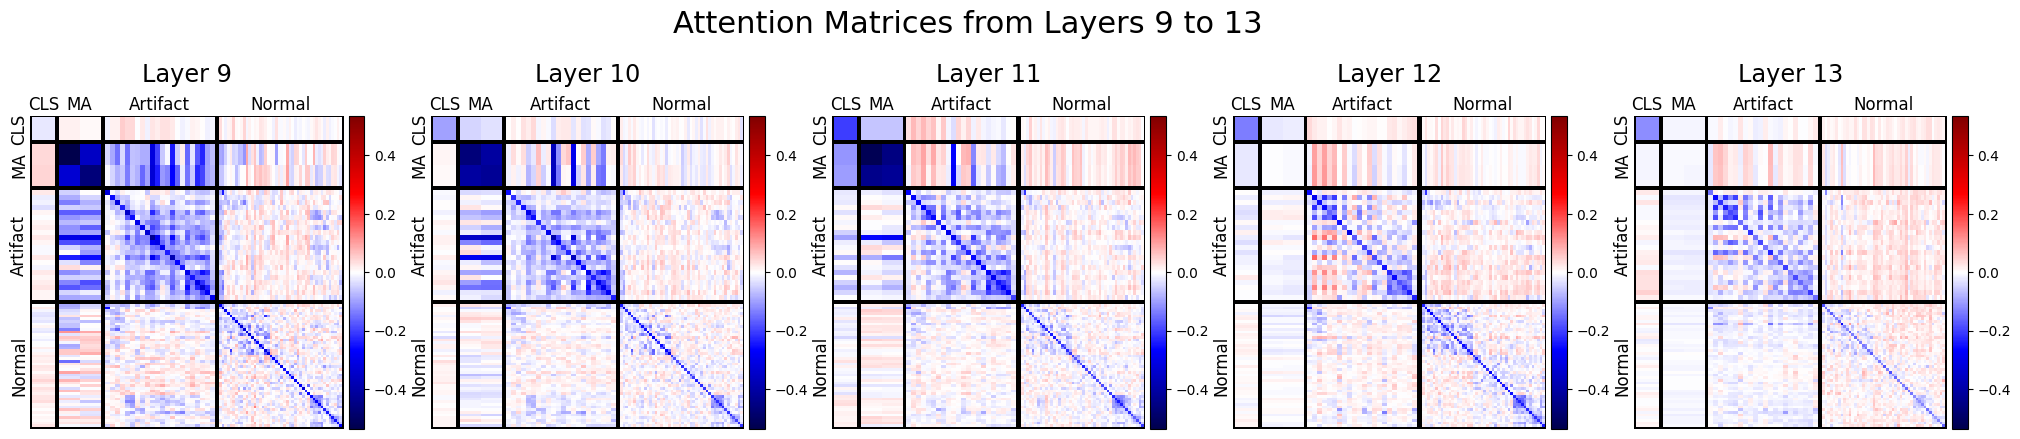

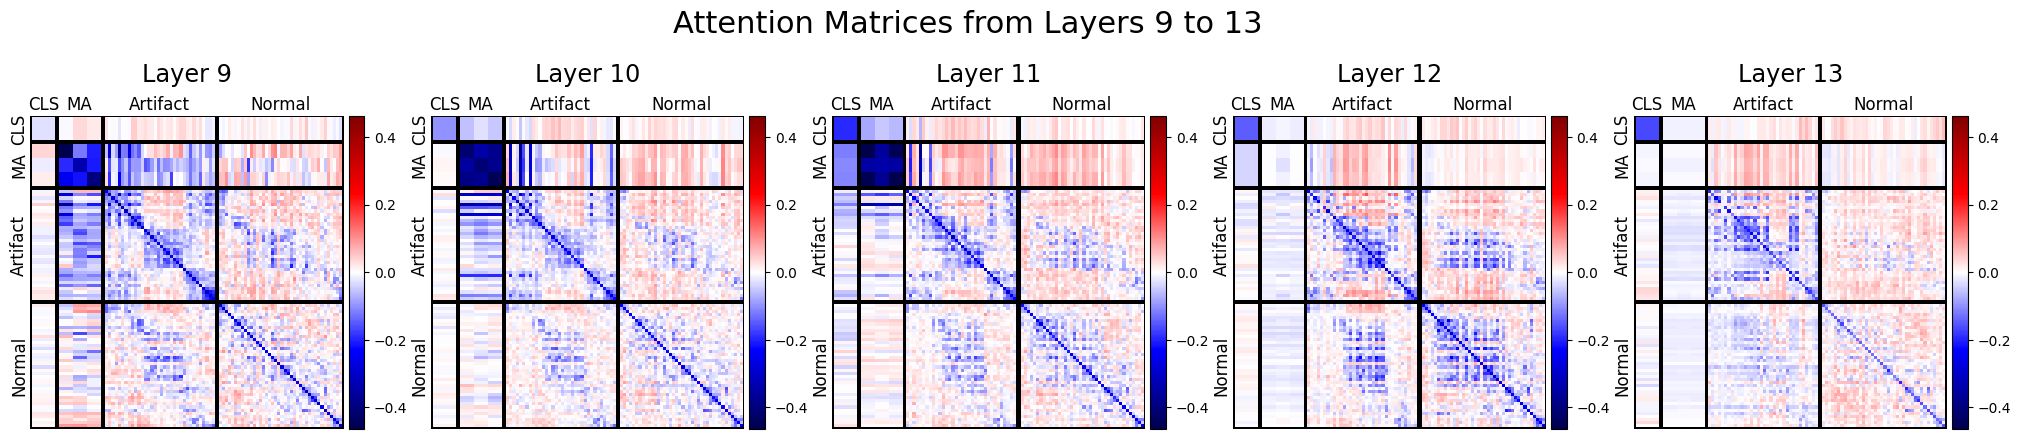

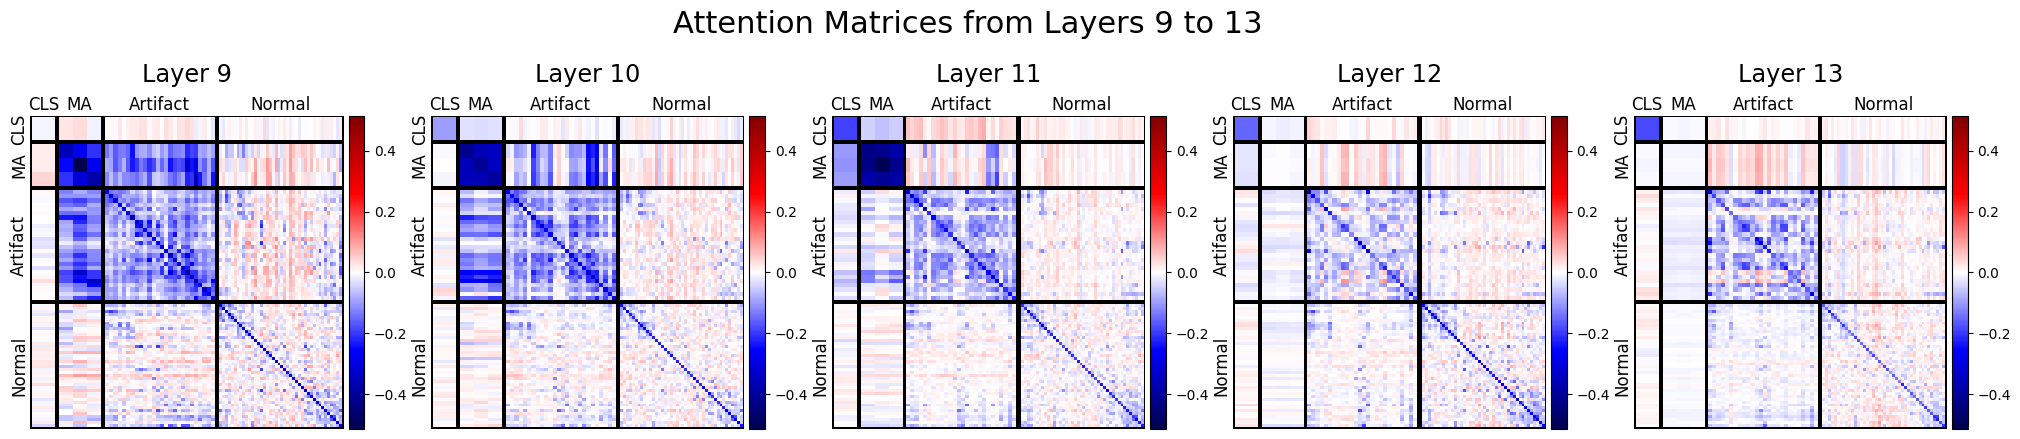

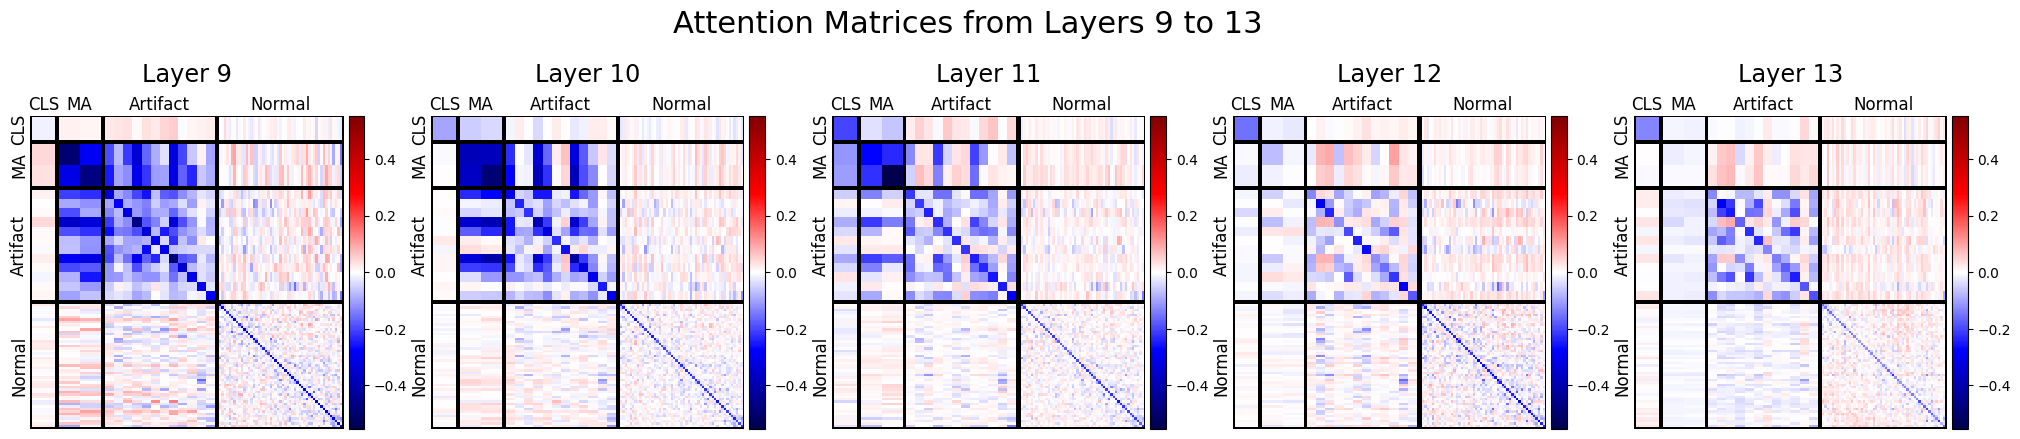

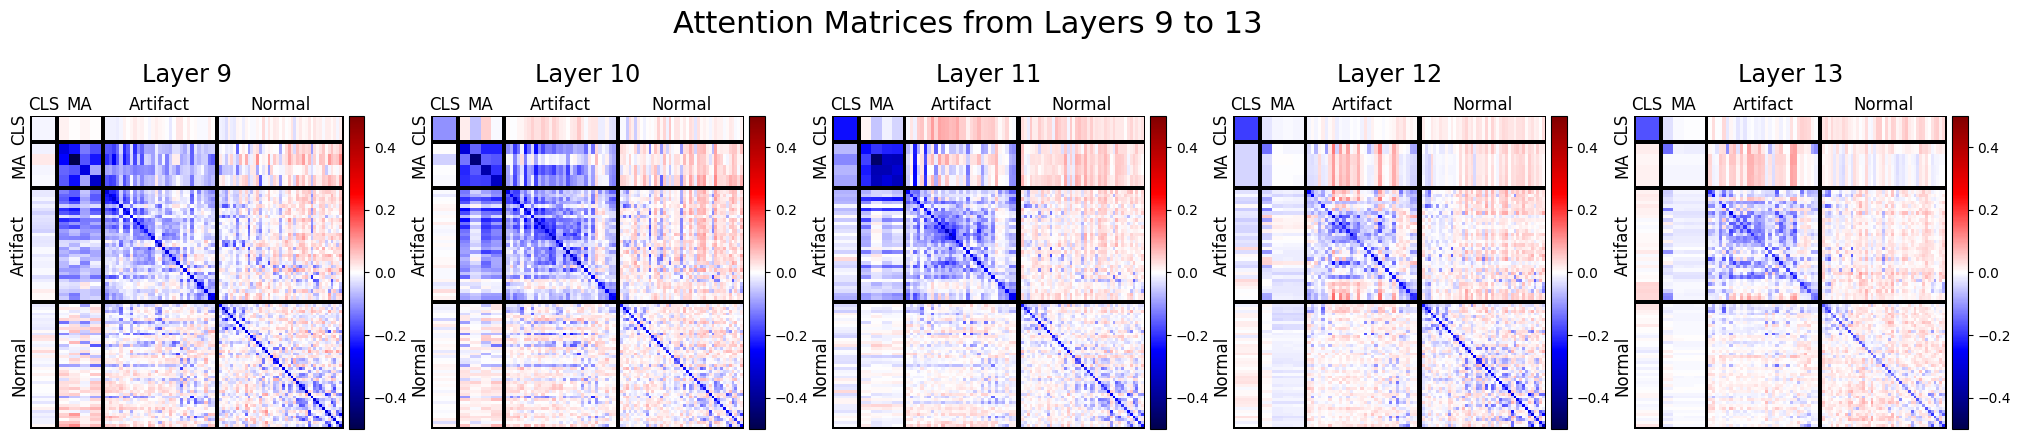

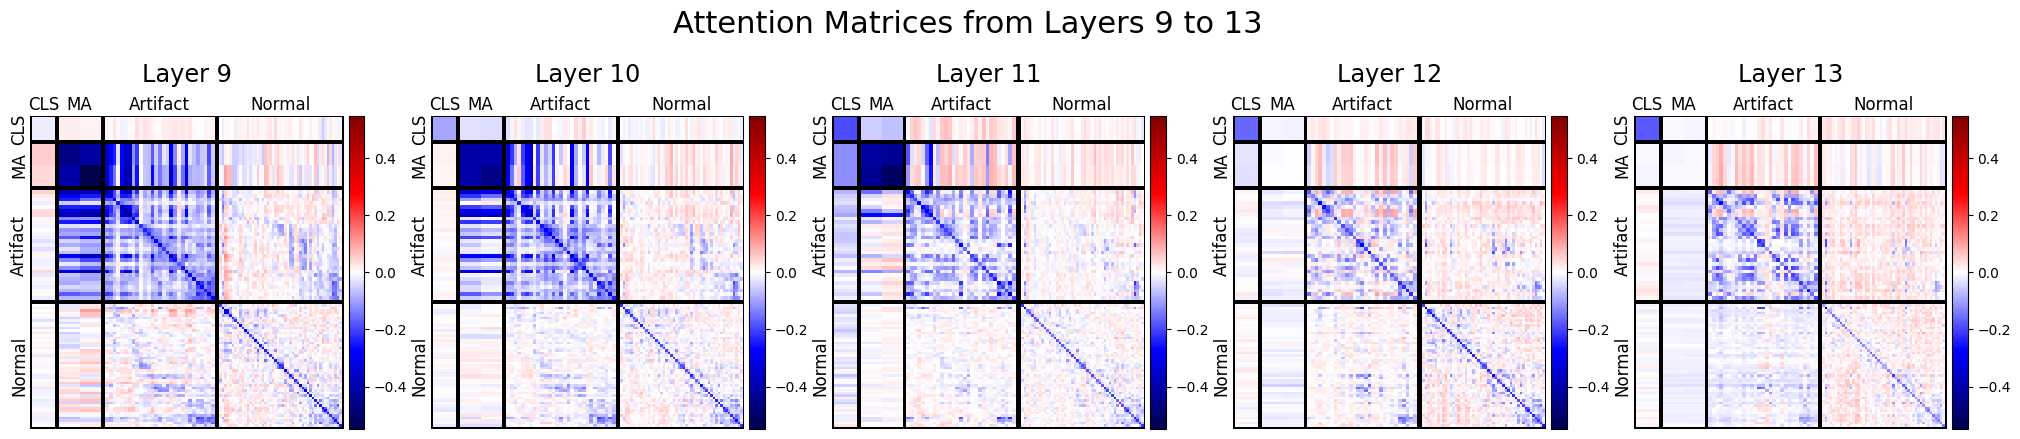

In [5]:
plotting_kwargs: Dict[str, Any] = {
    "transform_func": None,
    # "order_by_tsne": False,
    # "per_head": False,
    "rescale_func": lambda t: torch.log2(t + 1),
    "global_cmap": True,
    "cmap_scale": "linear",
    "subsample": 0.2,
    "spacing": 0.1,
    "cmap": "viridis",
}
visualize_attention_suppression_per_layer(
    [*range(9, 14)], features, model_weights, empirical=False, normalize=False, name_to_mask=mta_masks, save_fname=f"{OUTPUT_DIR}/{EXPERIMENT_DIR}/suppression_matrix",
    **plotting_kwargs,
)